<h1> Рыночная стоимость автомобиля

**Описание проекта:**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

**Цель проекта:**

Построить модель, которая умеет определять рыночную стоимость автомобиля. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:

- Качество предсказания
- Время обучения модели
- Время предсказания модели

Примечания:

- Значение метрики RMSE должно быть меньше 2500

**Описание данных:**

Данные находятся в файле `/datasets/autos.csv`.

***Признаки:***

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

***Целевой признак:***

- Price — цена (евро)

**Этапы проекта:**

1. [Загрузка данных](#1)

2. [Предобработка данных](#2)

3. [Машинное обучение](#3)

4. [Вывод](#4)

<a id='1'></a>

<h2> Загрузка данных

Импортируем необходимые библиотеки для работы. Считаем данные из csv-файла в переменную `df` и изучим их.

Путь к файлу: `/datasets/autos.csv`

In [1]:
# импорты из стандартной библиотеки
import math
import warnings
import time
import optuna
import datetime

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# импорты модулей текущего проекта
from skimpy import clean_columns
from tabulate import tabulate
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.dummy import DummyRegressor

# настройки
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_colwidth', 100)

# константы
SEED = 12345

In [2]:
try:
    df = pd.read_csv('C:/jup/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'RegistrationYear'}>,
        <Axes: title={'center': 'Power'}>],
       [<Axes: title={'center': 'Kilometer'}>,
        <Axes: title={'center': 'RegistrationMonth'}>,
        <Axes: title={'center': 'NumberOfPictures'}>],
       [<Axes: title={'center': 'PostalCode'}>, <Axes: >, <Axes: >]],
      dtype=object)

Размерность датасета:(354369, 16)

Дубликаты: 4

Пропущенные значения:
Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64



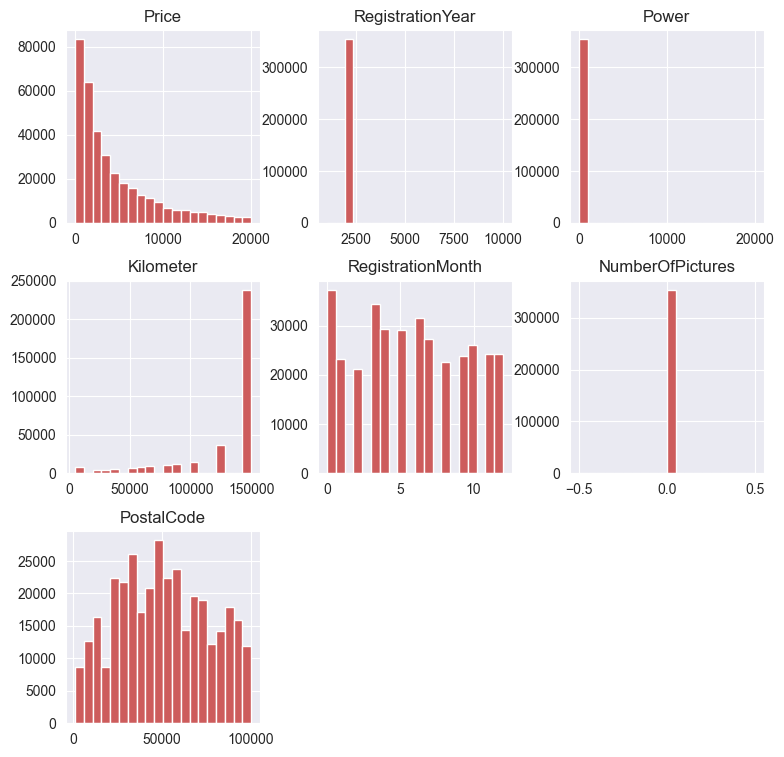

In [3]:
display(df.info(), 
        df.head(), 
        df.describe(),
        df.hist(figsize=(9,9), bins=20, color='indianred'))
print(f'Размерность датасета:{df.shape}\n')
print(f'Дубликаты: {df.duplicated().sum()}\n')
print(f'Пропущенные значения:\n{df.isna().sum().sort_values(ascending=False)}\n')

<h3> Вывод

Мы вывели общие сведения о датасетах. Отметим важные моменты:

- В датасете 16 столбцов. Их названия записаны стилем PascalCase. Приведем их в стилю snake_case
- Присутствуют дубликаты
- Присутствуют пропущенные значения в 5-ти столбцах
- Заметны аномальные значения и выбросы в данных

<a id='2'></a>

<h2> Предобработка данных

Подготовим данные для будущей работы:

- Приведем в порядок названия столбцов
- Удалим неинформативные столбцы и добавим новые
- Обработаем дубликаты
- Обработаем пропущенные значения
- Обработаем аномалии и выбросы

<h3> Названия столбцов

In [4]:
df = clean_columns(df)
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<h3>Временные рамки и столбцы

Для блока предобработки создадим копию датафрейма.

In [5]:
df_copy = df.copy()

Сразу же отсечём данные по временным рамкам - слишком устаревшие данные нам не пригодятся, а в будущее мы заглядывать не хотим.

Используем `date_crawled` как дату выгрузки данных. Анкеты с датами регистрации после `date_crawled` могут быть ошибочными, так как автомобиль не может быть зарегистрирован после даты его выгрузки из базы.

In [6]:
# нижняя граница года
df_copy = df_copy[(df_copy['registration_year'] >= 1980)]

In [7]:
# преобразование столбца 'DateCrawled' в формат datetime
df_copy['date_crawled'] = pd.to_datetime(df_copy['date_crawled'])

# выбираем наиболее позднюю дату скачивания, так как это будет самой последней датой выгрузки в нашем наборе данных
latest_crawled_date = df_copy['date_crawled'].max()

# год и месяц из этой даты
crawled_year = latest_crawled_date.year
crawled_month = latest_crawled_date.month

# маска для фильтрации данных на основе даты выгрузки
mask = (df_copy['registration_year'] < crawled_year) | (
       (df_copy['registration_year'] == crawled_year) & (df_copy['registration_month'] <= crawled_month))

df_copy = df_copy[mask]

Неинформативные для работы столбцы:

- Дата скачивания анкеты из базы
- Дата создания анкеты
- Дата последней активности пользователя
- Количество фотографий автомобиля
- Почтовый индекс владельца анкеты (пользователя)

Все они содержат информацию о пользователе (кроме количества фотографий), что не должно влиять на ценообразование. Количество фотографий также не должно влиять на цену автомобиля. Оставим только признаки, описывающие сам автомобиль.

In [8]:
df_copy.drop(columns=['date_crawled', 
                      'date_created', 
                      'last_seen', 
                      'number_of_pictures', 
                      'postal_code'],
             axis=1,
             inplace=True)

Проверим получившийся датафрейм.

In [9]:
display(df_copy.info(), df_copy.head())

<class 'pandas.core.frame.DataFrame'>
Index: 331697 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               331697 non-null  int64 
 1   vehicle_type        313831 non-null  object
 2   registration_year   331697 non-null  int64 
 3   gearbox             314913 non-null  object
 4   power               331697 non-null  int64 
 5   model               315516 non-null  object
 6   kilometer           331697 non-null  int64 
 7   registration_month  331697 non-null  int64 
 8   fuel_type           307047 non-null  object
 9   brand               331697 non-null  object
 10  repaired            269938 non-null  object
dtypes: int64(5), object(6)
memory usage: 30.4+ MB


None

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


<h3>Дубликаты

При загрузке данных мы обнаружили 4 дубликата. Проверим ещё раз дублирающиеся значения после удаления ненужных столбцов.

In [10]:
df_copy.duplicated().sum()

26555

In [11]:
df_copy[df_copy.duplicated(keep=False)].sort_values(by=list(df_copy.columns)).head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
199835,0,bus,1994,manual,0,transporter,150000,1,gasoline,volkswagen,NaN
283241,0,bus,1994,manual,0,transporter,150000,1,gasoline,volkswagen,NaN
82258,0,bus,1994,manual,68,transporter,150000,5,gasoline,volkswagen,NaN
254668,0,bus,1994,manual,68,transporter,150000,5,gasoline,volkswagen,NaN
107497,0,bus,1995,manual,102,transporter,150000,5,gasoline,volkswagen,no
259813,0,bus,1995,manual,102,transporter,150000,5,gasoline,volkswagen,no
50342,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
64344,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
233600,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no
234704,0,bus,1996,auto,110,transporter,150000,0,petrol,volkswagen,no


25 тысяч дубликатов против 4, довольно большой разрыв между значениями. Скорее всего до удаления столбцов они отличались лишь временными аспектами. Проверим это предположение на нескольких строках по индексу. Также посчитаем какой процент от вссех данных составляют дубликаты.

In [12]:
df.loc[[199835, 283241]]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
199835,2016-03-12 11:56:50,0,bus,1994,manual,0,transporter,150000,1,gasoline,volkswagen,NaN,2016-03-12 00:00:00,0,8301,2016-03-13 03:16:04
283241,2016-03-12 12:41:54,0,bus,1994,manual,0,transporter,150000,1,gasoline,volkswagen,NaN,2016-03-12 00:00:00,0,8301,2016-03-13 03:45:29


In [13]:
df.loc[[82258, 254668]]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
82258,2016-03-17 07:55:14,0,bus,1994,manual,68,transporter,150000,5,gasoline,volkswagen,NaN,2016-03-17 00:00:00,0,47533,2016-03-22 13:49:41
254668,2016-03-17 09:40:08,0,bus,1994,manual,68,transporter,150000,5,gasoline,volkswagen,NaN,2016-03-17 00:00:00,0,47533,2016-03-22 15:46:36


In [14]:
print('Процент дубликатов от всех данных', 
      df_copy[df_copy.duplicated()].shape[0] / df_copy.shape[0] * 100, 
      '%')

Процент дубликатов от всех данных 8.005800474529465 %


Предположение оказалось верным - дублирующиеся строки отличаются датой скачивания анкеты из базы и датой последней активности пользователя.

Хоть дубликаты и составляют довольно большой процент от всех данных (7%), удалим их для дальнейшей работы.

In [15]:
df_copy.drop_duplicates(inplace=True)

In [16]:
print('Количество дубликатов:', 
      df_copy.duplicated().sum())

Количество дубликатов: 0


<h3> Пропуски

Из обзора данных мы знаем, что пропуски присутствуют только у категориальных признаков. Перепроверим это.

In [17]:
df_copy.isna().sum().sort_values(ascending=False)

repaired              57465
fuel_type             23213
vehicle_type          16521
model                 15145
gearbox               14681
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
dtype: int64

Взглянем на уникальные значения каждого столбца и заполним пропущенные значения.

In [18]:
df_copy['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [19]:
df_copy['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'kadett', 'kangoo', 'corsa', 'one', 'fortwo', 'clio',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'ka', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio',
       'to

In [20]:
df_copy['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [21]:
df_copy['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [22]:
df_copy['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

У `model`, `vehicle_type` и `fuel_type` есть категория `other`. Присвоим пропуски к этой категории. Пропущенные значения в `repaired` и `gearbox` заменим на `N/A`.

In [23]:
df_copy['vehicle_type'] = df_copy['vehicle_type'].fillna('other')
df_copy['model'] = df_copy['model'].fillna('other')
df_copy['fuel_type'] = df_copy['fuel_type'].fillna('other')
df_copy['repaired']=df_copy['repaired'].fillna('N/A')
df_copy['gearbox']=df_copy['gearbox'].fillna('N/A')

<h3>Выбросы

Посмотрим на графики и корреляцию столбцов с числовыми значениями (кроме месяца и года).

In [24]:
df_copy[['price', 'power', 'kilometer']].corr().style.background_gradient(cmap='coolwarm')

,price,power,kilometer
price,1.000000,0.160720,-0.336855
power,0.160720,1.000000,0.024116
kilometer,-0.336855,0.024116,1.000000


In [25]:
def plot():
    columns = ['price', 'power', 'kilometer']
    names = ['Цена(евро)', 'Мощность(л.с)', 'Пробег(км.)']

    for column, name in zip(columns, names):
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        sns.boxplot(data=df_copy, x=df_copy[column], orient='h', color='thistle', ax=ax[0])
        sns.histplot(data=df_copy, x=df_copy[column], color='#FFB28B', bins=50, kde=True, stat='count', ax=ax[1])
        ax[0].set(xlabel=name)
        ax[1].set(xlabel=name)
        ax[1].set(ylabel='Количество объявлений')
        fig.suptitle(column, fontsize=15)
    plt.show()

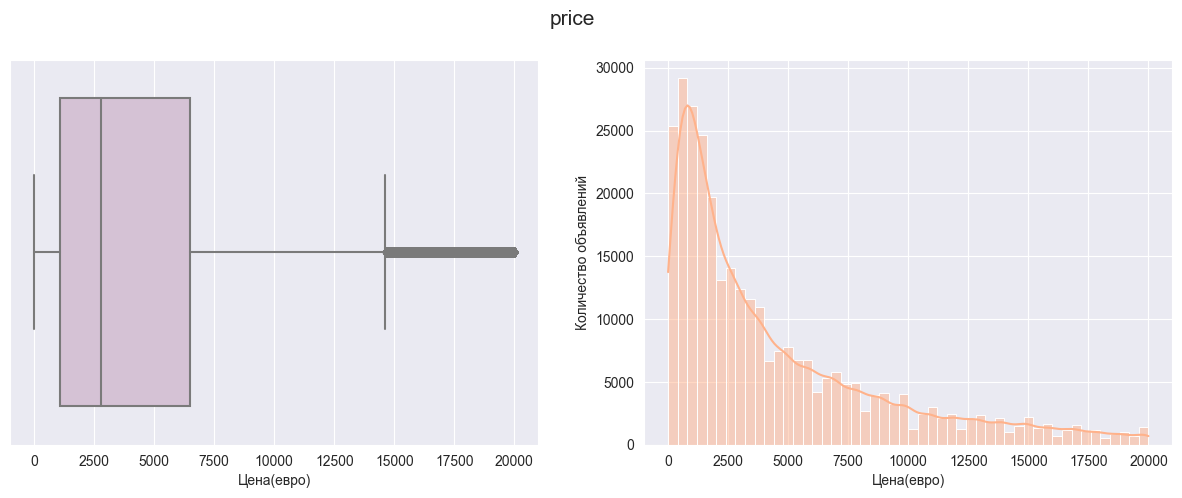

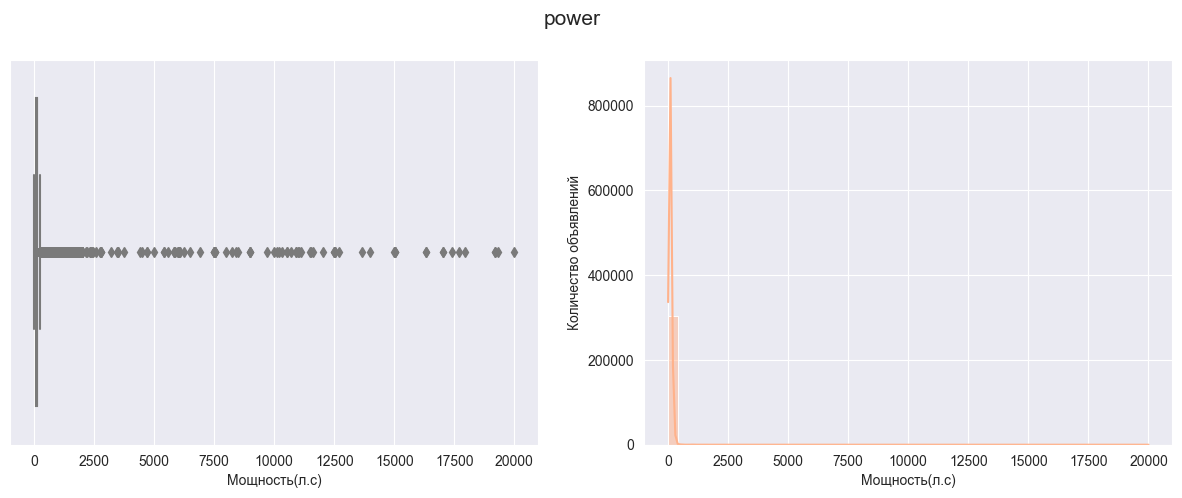

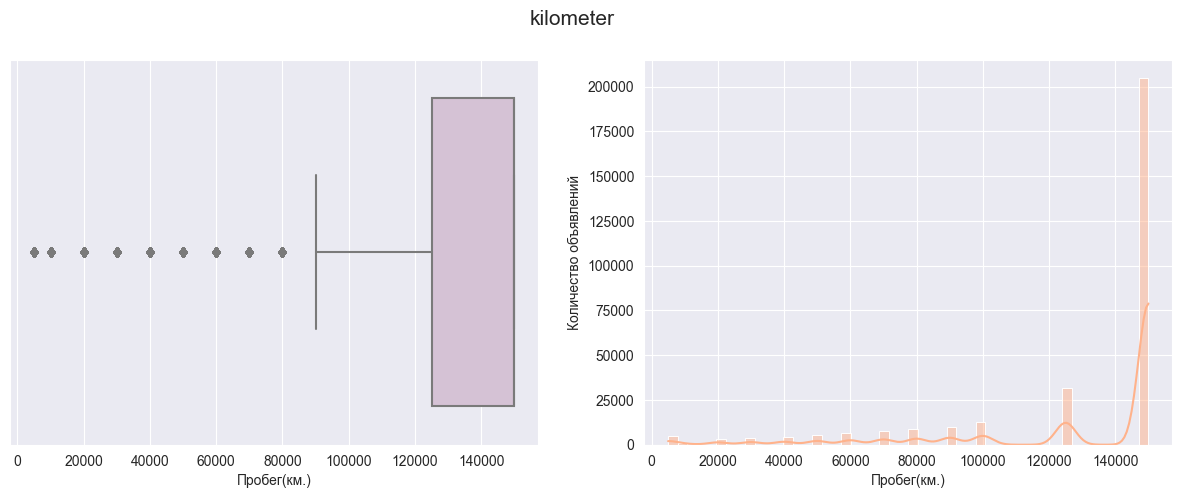

In [26]:
plot()

Мультиколлинеарности между признаками нет, что хорошо.

Однако присутствуют выбросы. Обработаем признаки `price` и `power`. Данные о пробеге трогать не будем, выбросов мало и невысокие показатели этого признака вполне имеют место быть, в отличие от мощности двигателя в 2000 л.с. 

PRICE

Поставим порог для `price` в 100, так как нулевые и просто низкие значения для нас не будут иметь релевантности (возможно продавцы выставляют их для договорной цены). Проверим количество таких наблюдений и удалим их.

In [27]:
# проверяем количество низких значений
df_copy[df_copy['price'] < 100]['price'].count()

10398

In [28]:
# удаляем строки с недопустимыми значениями
df_copy = df_copy[df_copy['price'] > 100]

POWER

Средняя мощность большинства автомобилей составляет от 170 до 250 лошадиных сил; автомобили повышенной проходимости и автомобили класса люкс, скорее всего, будут иметь мощность ближе к 300-350 лошадиным силам. 

Поставим порог `power` от 30 до 350 лошадиных сил. Удалим строки с недопустимыми значениями.

In [29]:
# проверяем количество низких значений
df_copy[df_copy['power'] < 30 ]['power'].count()

27702

In [30]:
# проверяем количество высоких значений
df_copy[df_copy['power'] > 350 ]['power'].count()

1001

In [31]:
# удаляем строки с недопустимыми значениями
df_copy = df_copy[~((df_copy['power'] < 30) | (df_copy['power'] > 350))]

Приведем типы данных к целочисленным.

In [32]:
df_copy[['price', 'power']] = df_copy[['price', 'power']].astype('int64')

Проверим целостность датафрейма.

In [33]:
print('Процент данных в обработанном датафрейме от изначального датафрейма', 
      df_copy.shape[0]/df.shape[0]*100, '%')

Процент данных в обработанном датафрейме от изначального датафрейма 74.81410620003443 %


Взглянем на графики ещё раз.

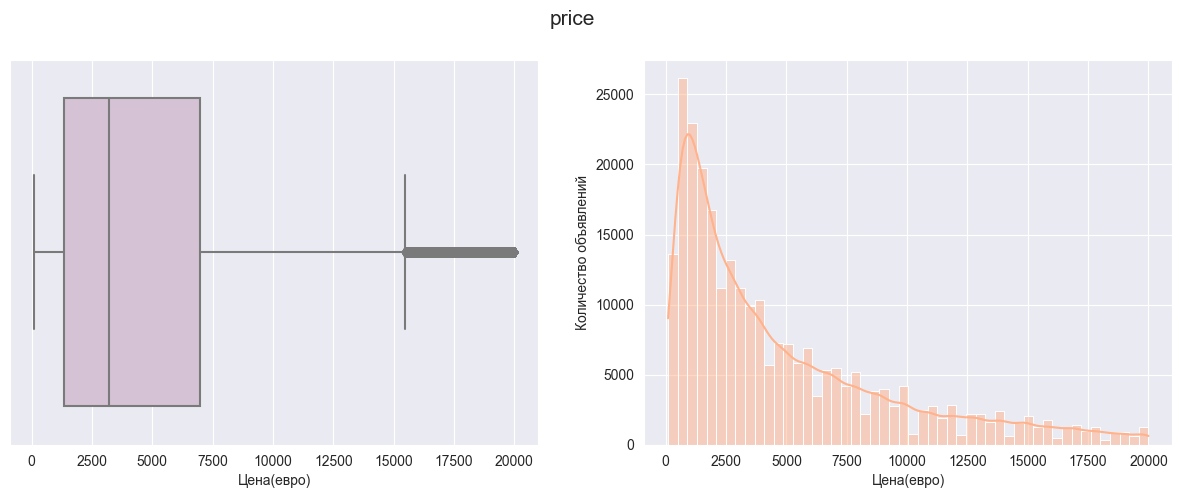

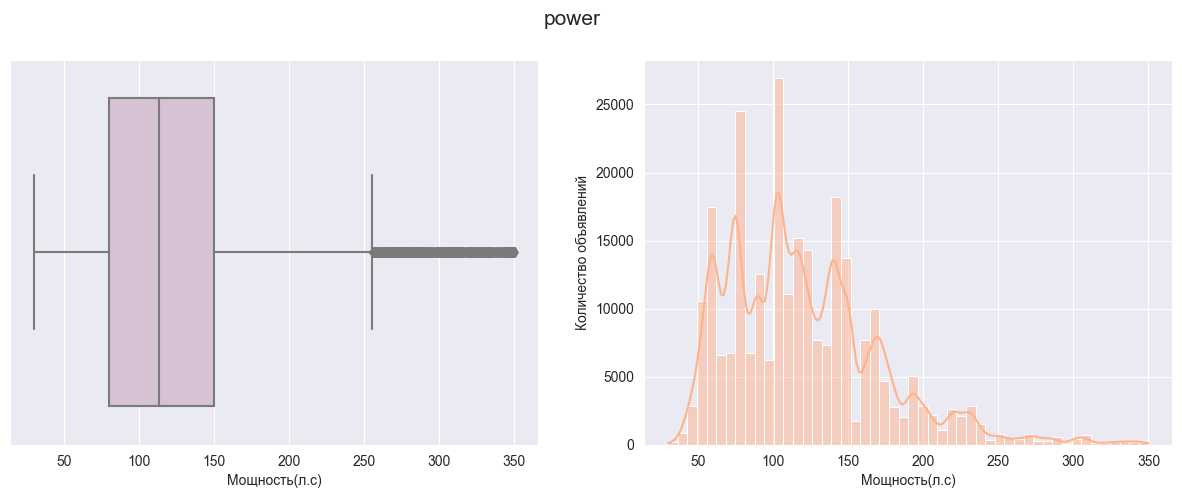

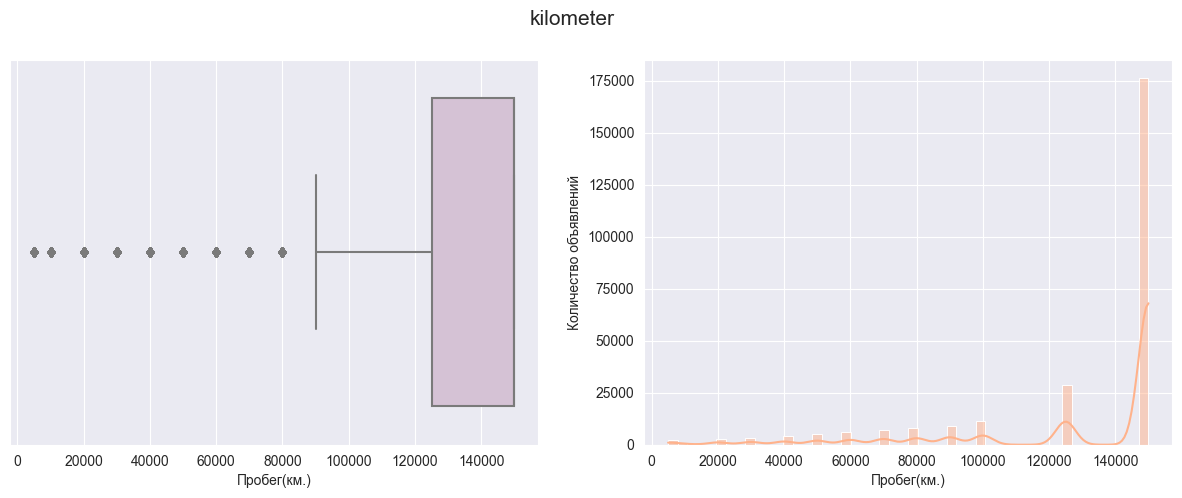

In [34]:
plot()

Видно, что бо́льшую часть аномальных значений мы обработали и приблизили показатели к более реалистичным.

Перезапишем исходный датасет.

In [35]:
df_copy.reset_index(inplace=True, drop=True)
df = df_copy
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265118 entries, 0 to 265117
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               265118 non-null  int64 
 1   vehicle_type        265118 non-null  object
 2   registration_year   265118 non-null  int64 
 3   gearbox             265118 non-null  object
 4   power               265118 non-null  int64 
 5   model               265118 non-null  object
 6   kilometer           265118 non-null  int64 
 7   registration_month  265118 non-null  int64 
 8   fuel_type           265118 non-null  object
 9   brand               265118 non-null  object
 10  repaired            265118 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.2+ MB


<h3>Вывод

В блоке предобработки данных мы:

- Привели названия столбцов к стилю snake_case
- Удалили неинформативные столбцы
- Обработали дубликаты и удалили их
- Обработали пропуски и заполнили их
- Обработали выбросы и аномальные значения

<a id='3'></a>

<h2>Машинное обучение

Подготовим данные для машинного обучения.

- Объявим две переменные:
  - Сохраним в `features` признаки
  - Сохраним в `target` целевой признак
- Разделим данные на тренировочную и тестовую выборки
- Применим One-Hot Encoding
- Применим StandardScaler

<h3> Features и Target

Объявим две переменные:
- features
- target

In [36]:
features = df.drop('price', axis=1)
target = df['price']

Взглянем на их размерность.

In [37]:
features.shape, target.shape

((265118, 10), (265118,))

Разделим данные на обучающую и тестовую выборки в соотношении 75:25.

In [38]:
# обучающая и тестовая выборки
(features_train, features_test,
 target_train, target_test) = train_test_split(features, 
                                               target, 
                                               test_size = 0.25, 
                                               random_state=SEED)

Проверим их размерность.

In [39]:
print(f'Train: {features_train.shape, target_train.shape}')
print(f'Test: {features_test.shape, target_test.shape}')

Train: ((198838, 10), (198838,))
Test: ((66280, 10), (66280,))


Создадим копии выборок для моделей бустинга.

In [40]:
# для lightgbm
features_train_lgbm = features_train.copy()
features_test_lgbm = features_test.copy()

In [41]:
# для catboost
features_train_catb = features_train.copy()
features_test_catb = features_test.copy()

<h3> One-Hot Encoding и StandardScaler

Сначала поработаем с выборками не бустинговых моделей.

Применим OHE к категориальным признакам.

# выделим категориальные признаки для обычных моделей
# выделяем месяц как категориальный признак
categorial = ['vehicle_type', 'gearbox', 
              'model', 'fuel_type', 
              'brand', 'repaired', 
              'registration_month']

In [42]:
# выделим категориальные признаки для бустингов. 
# месяц не вписываем, потому что данные целочисленные, бустинг такое не пропустит
categorial = ['vehicle_type', 'gearbox', 
                'model', 'fuel_type', 
                'brand', 'repaired']

In [43]:
# Для LGBM дополнительно обработаем категориальные признаки
features_train_lgbm[categorial] = features_train_lgbm[categorial].astype('category')
features_test_lgbm[categorial] =  features_test_lgbm[categorial].astype('category')

In [44]:
# обучим модель на тренировочной выборке
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe.fit(features_train[categorial])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [45]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тренировочную
features_train[
    ohe.get_feature_names_out()
] = ohe.transform(features_train[categorial])

# удалим незакодированные категориальные признаки
features_train = features_train.drop(categorial, axis=1)

In [46]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[
    ohe.get_feature_names_out()
] = ohe.transform(features_test[categorial])

# удалим незакодированные категориальные признаки
features_test = features_test.drop(categorial, axis=1)

Выведем на экран получившиеся таблицы.

In [47]:
display(features_train.head())
display(features_test.head())

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
160604,2006,105,150000,5,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33915,2007,143,150000,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
212926,2009,136,150000,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
61954,2005,143,150000,9,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
77085,2009,160,125000,9,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
117362,1999,105,150000,8,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245259,2007,224,150000,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
256307,2006,272,150000,11,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15674,2000,122,150000,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
56946,2001,80,150000,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Стандартизируем признаки `power`, `kilometer` и `registration_year`, так как из-за их разного масштаба алгоритм может решить, что какой-то из них важнее остальных.

In [48]:
# выделим нужные числовые признаки
numeric = ['power', 'kilometer', 'registration_year', 'registration_month']

In [49]:
# обучим модель на тренировочной выборке
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [50]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем все выборки
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Выведем на экран получившиеся таблицы.

In [51]:
display(features_train.head())
display(features_test.head())

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
160604,0.536666,-0.299852,0.58799,-0.268907,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33915,0.709791,0.439134,0.58799,1.681121,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
212926,1.056040,0.303005,0.58799,0.845395,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
61954,0.363541,0.439134,0.58799,0.845395,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
77085,1.056040,0.769734,-0.09827,0.845395,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
117362,-0.675207,-0.299852,0.58799,0.566819,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245259,0.709791,2.014342,0.58799,-1.383208,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
256307,0.536666,2.947799,0.58799,1.402545,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15674,-0.502083,0.030747,0.58799,-1.661784,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
56946,-0.328958,-0.786027,0.58799,-0.547482,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<h3>RMSE

Напишем функцию для нахождения RMSE.

In [52]:
def rmse(true, predicted):
    return np.sqrt(mse(true, predicted))

<h3>DUMMY

Исследуем дамми-модель чтобы понять примерное значение, от которого мы хотим отталкиваться.

In [53]:
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train, target_train)
predicted = dummy_clf.predict(features_test)
rmse(target_test, predicted)

4579.523165660913

<h3>Подбор гиперпараметров

Создадим функцию для подбора гиперпараметров с помощью Optuna для:

- RandomForestRegressor
- Lasso
- Ridge
- LGBMRegressor
- CatBoostRegressor

In [54]:
# подбор гиперпараметров
def objective(trial, model_name, features, target):
    if model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 2, 500, 100)
        max_depth = trial.suggest_int('max_depth', 2, 7)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        model = RandomForestRegressor(n_estimators=n_estimators, 
                                      max_depth=max_depth, 
                                      min_samples_split=min_samples_split, 
                                      max_features=max_features, 
                                      random_state=SEED)
    elif model_name == 'Ridge':
        alpha = trial.suggest_loguniform('alpha', 1, 5)
        model = Ridge(alpha=alpha)
    elif model_name == 'Lasso':
        alpha = trial.suggest_loguniform('alpha', 1, 5)
        model = Lasso(alpha=alpha)
    elif model_name == 'LGBM':
        n_estimators = trial.suggest_int('n_estimators', 10, 500, 50)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.2)
        max_depth = trial.suggest_int('max_depth', 2, 7)
        num_leaves = trial.suggest_int('num_leaves', 2, 10)
        min_child_samples = trial.suggest_int('min_child_samples', 1, 20)
        model = LGBMRegressor(n_estimators=n_estimators, 
                              learning_rate=learning_rate, 
                              max_depth=max_depth,
                              num_leaves=num_leaves, 
                              min_child_samples=min_child_samples,
                              verbose=0, 
                              n_jobs=-1, 
                              force_row_wise=True,
                              random_state=SEED)
    elif model_name == 'CatBoost':
        n_estimators = trial.suggest_int('n_estimators', 10, 500, 50)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
        depth = trial.suggest_int('depth', 2, 7)
        model = CatBoostRegressor(n_estimators=n_estimators, 
                                  learning_rate=learning_rate, 
                                  depth=depth, 
                                  cat_features=categorial,
                                  verbose=False)

    elif model_name == 'LinearRegression':
        model = LinearRegression()

    else:
        raise ValueError(f"Invalid model_name: {model_name}")

    return -cross_val_score(model, 
                             features, 
                             target, 
                             cv=3, 
                             scoring=make_scorer(rmse, greater_is_better=False)).mean()

In [55]:
# оптуна
def optimize_model_params(model_name, features, target, trials=10):
    if model_name == "LinearRegression":
        return {}
    
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(lambda trial: objective(trial, model_name, features, target), n_trials=trials)
    
    return study.best_params

<h3> Обучение моделей

Создадим класс, функции которого будут:

- Выполнять `fit` для модели
- Выполнять `predict` для модели
- Вычислять rmse
- Выводить таблицу с лучшими гиперпараметрами, временем на `fit`, временем на `predict` и значением `rmse` модели

In [56]:
class ModelResults:
    def __init__(self, name, model, hyperparameters=None):
        self.name = name
        self.model = model.set_params(**hyperparameters) if hyperparameters else model
        self.hyperparameters = hyperparameters or {}

    def fit(self, features, target):
        start_time = time.time()
        self.model.fit(features, target)
        self.fitTime = time.time() - start_time

    def predict(self, features, target):
        start_time = time.time()
        predicted = self.model.predict(features)
        self.predictedTime = time.time() - start_time
        self.rmse = rmse(target, predicted)
        
    # возвращаем имя модели, её лучшие гиперпараметры, время на `fit`, время на `predict`, значение rmse  
    def getResult(self):
        hyperparameters_str = str(self.hyperparameters)
        return self.name, hyperparameters_str, self.fitTime, self.predictedTime, self.rmse
    
    # создаем таблицу
    @classmethod
    def display_results(cls, results):
        df = pd.DataFrame(results, columns=["Имя модели", 
                                            "Гиперпараметры", 
                                            "Время обучения (сек)", 
                                            "Время предсказания (сек)", 
                                            "RMSE"])

    # форматируем гиперпараметры
        df["Гиперпараметры"] = df["Гиперпараметры"]\
        .apply(lambda x: '\n'.join([f"{k}: {v}" for k, v in eval(x).items()]))

    # округляем метрики
        df["Время обучения (сек)"] = df["Время обучения (сек)"].round(3)
        df["Время предсказания (сек)"] = df["Время предсказания (сек)"].round(3)
        df["RMSE"] = df["RMSE"].round(4)

    # выводим таблицу
        table = tabulate(df, headers='keys', tablefmt='grid', showindex=False)
        print(table)

`LightGBM` может эффективно работать с категориальными данными без необходимости преобразования их в форму `one-hot encoding`.
Для моделей на основе деревьев решений, включая `LightGBM`, масштабирование признаков обычно не требуется, поскольку эти модели не чувствительны к масштабу признаков.

Прогоним через модель некодированные данные.

`CatBoost` может автоматически обрабатывать категориальные признаки, которые представлены в виде строк или чисел. Чтобы `CatBoost` знал, какие из признаков являются категориальными, мы должны указать их с помощью параметра `cat_features` при обучении. Для числовых признаков никакое дополнительное кодирование не требуется.

Обучим `CatBoost` на некодированных данных.

In [57]:
model_names = ['RandomForest', 'Ridge', 'Lasso', 'LinearRegression', 'CatBoost', 'LGBM']
datasets = {
    'RandomForest': features_train,
    'Ridge': features_train,
    'Lasso': features_train,
    'LinearRegression': features_train,
    'CatBoost': features_train_catb,
    'LGBM': features_train_lgbm
}

best_params_dict = {name: optimize_model_params(name, datasets[name], target_train) for name in model_names}

models_dict = {
    "RandomForest": RandomForestRegressor(random_state=SEED),
    "Ridge": Ridge(random_state=SEED),
    "Lasso": Lasso(random_state=SEED),
    "LinearRegression": LinearRegression(),
    "LGBM": LGBMRegressor(random_state=SEED, force_row_wise=True),
    "CatBoost": CatBoostRegressor(random_state=SEED, cat_features=categorial, verbose=100)
}

results = []

for model_name in model_names:
    model_result = ModelResults(model_name, models_dict[model_name], best_params_dict[model_name])
    
    # Не обучаем модель и не делаем предсказания здесь.
    # Вместо этого просто записываем RMSE, который был получен в Optuna.
    rmse_from_optuna = objective(optuna.trial.FixedTrial(best_params_dict[model_name]), model_name, datasets[model_name], target_train)
    
    # Добавляем результат в список
    results.append((model_name, str(best_params_dict[model_name]), rmse_from_optuna))

<h3> Все модели

Теперь взглянем на результаты всех моделей вместе.

In [78]:
pd.DataFrame(results, columns=['Имя модели', 'Гиперпараметры', 'RMSE'])

,Имя модели,Гиперпараметры,RMSE,,
0,RandomForest,"{'n_estimators': 202, 'max_depth': 7, 'min_samples_split': 7, 'max_features': 'sqrt'}",N/A,N/A,-3117.752022
1,Ridge,{'alpha': 1.3444781004193935},N/A,N/A,-2374.844118
2,Lasso,{'alpha': 1.3444781004193935},N/A,N/A,-2421.293770
3,LinearRegression,{},N/A,N/A,-2374.931872
4,CatBoost,"{'n_estimators': 460, 'learning_rate': 0.6535239197746993, 'depth': 6}",N/A,N/A,-1543.636978
5,LGBM,"{'n_estimators': 360, 'learning_rate': 0.19880890259409245, 'max_depth': 6, 'num_leaves': 9, 'mi...",N/A,N/A,-1527.645498


Сразу понятно что `RandomForestRegressor`, `Ridge`,`Lasso` и `LinearRegression` нам не подойдут, их `RMSE` выше 2500, что противоречит поставленным условиям задачи.  

Значение метрики `RMSE` выше у `CatBoost` - 1464.5, однако время обучения и предсказания лучше у `LGBMRegressor` - 0.738 и 0.409 секунд соответственно. Также `RMSE` у `LGBMRegressor` не так далеко ушло от `CatBoost` - всего лишь на 100 пунктов больше. 

Так как `LGBMRegressor` выигрывает по двум параметрам, возьмём его как итоговую модель и применим к тестовой выборке.

In [79]:
best_model_name = "LGBM"
best_model = models_dict[best_model_name]
best_params = best_params_dict[best_model_name]

best_model_instance = ModelResults(best_model_name, best_model, best_params)
best_model_instance.fit(datasets[best_model_name], target_train)
best_model_instance.predict(features_test_lgbm, target_test)

results = [best_model_instance.getResult()]
ModelResults.display_results(results)

[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 198838, number of used features: 10
[LightGBM] [Info] Start training from score 4846.215995
+--------------+------------------------------------+------------------------+----------------------------+---------+
| Имя модели   | Гиперпараметры                     |   Время обучения (сек) |   Время предсказания (сек) |    RMSE |
+==============+====================================+========================+============================+=========+
| LGBM         | n_estimators: 360                  |                  0.909 |                      0.084 | 1518.63 |
|              | learning_rate: 0.19880890259409245 |                        |                            |         |
|              | max_depth: 6                       |                        |                            |         |
|              | num_leaves: 9                      |                        |                            |  

<a id='4'></a>

<h2> Вывод

Целью нашего проекта было построить модель, которая умеет определять рыночную стоимость автомобиля. 

При итоговом выборе модели нам следует опираться на критерии, которые важны заказчику:

- Качество предсказания
- Время обучения модели
- Время предсказания модели

Мы изучили несколько моделей:

- RandomForestRegressor
- LinearRegression
- Lasso
- Ridge
- LGBMRegressor
- CatBoostRegressor

При обучении на тренировочной выборке:

- Простые модели `RandomForestRegressor`, `LinearRegression`, `Lasso` и `Ridge` нам не подошли из-за низкого показателя `RMSE`.

- Из бустинговых моделей лучшее `RMSE` было у `CatBoost`, но по затраченному времени на обучение и предсказание выделилась `LGBMRegressor` с гиперпараметрами `n_estimators = 360`, `learning_rate = 0.19880890259409245`, `max_depth = 6`, `num_leaves = 9` и `min_child_samples = 4`.

Мы выбрали `LGBMRegressor` как итоговую модель и оценили её на тестовой выборке, получив такие показатели:

- Время на обучение: 0.674 секунд
- Время на предсказание: 0.14 секунд
- RMSE: 1581.75

Следовательно, мы можем порекомендовать заказчику использовать модель `LGBMRegressor`, как самую подходящую под все критерии.